In [1]:
# import required packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

from importlib.machinery import SourceFileLoader #Kim
#from src.data.make_dataset import merge_data
make_dataset = SourceFileLoader('make_dataset',r'C:\Users\Kim\Desktop\data_mining_1\src\data\make_dataset.py').load_module() #Kim
from make_dataset import merge_data #Kim
#from src.features.build_features import features,split_data,feature_engineering, drop_unnecessary_ft, get_unnecessary_ft
build_features = SourceFileLoader('build_features',r'C:\Users\Kim\Desktop\data_mining_1\src\features\build_features.py').load_module() #Kim
from build_features import features,split_data,feature_engineering, drop_unnecessary_ft, get_unnecessary_ft
from xgboost import XGBClassifier
pd.options.display.max_columns =70

# I. Import whole dataset

In [2]:
# merge the dataset at a whole (train, test & target data all together)
train_values = pd.read_csv('../data/external/train_values.csv', index_col='building_id')
train_target = pd.read_csv('../data/external/train_labels.csv', index_col='building_id')
test_values = pd.read_csv('../data/external/test_values.csv', index_col='building_id')

df=merge_data(train_values, train_target, test_values)
df=df.reset_index()
display(df)

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
0,802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3.0
1,28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2.0
2,94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3.0
3,590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2.0
4,201944,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347464,310028,4,605,3623,3,70,20,6,t,r,q,f,q,t,d,0,1,0,0,0,0,1,0,0,0,0,w,1,1,1,0,0,0,0,0,0,0,0,0,NaN
347465,663567,10,1407,11907,3,25,6,7,n,r,n,f,q,s,d,1,1,1,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,NaN
347466,1049160,22,1136,7712,1,50,3,3,t,r,n,f,j,s,d,0,1,0,0,0,0,1,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,NaN
347467,442785,6,1041,912,2,5,9,5,t,r,n,f,q,s,d,1,1,0,0,0,0,0,0,0,0,0,a,1,0,0,0,0,0,0,0,0,0,0,0,NaN


## Before Preprocessing: investigate means of several categorical features 

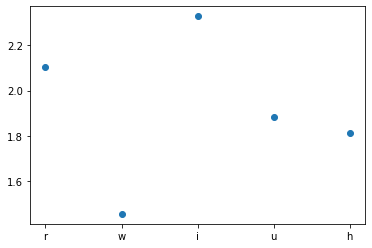

In [3]:
# investigate mean of damage grade depending on foundation type 
plt.scatter(df['foundation_type'].unique(),df.groupby(['foundation_type']).mean()['damage_grade'])
plt.show()

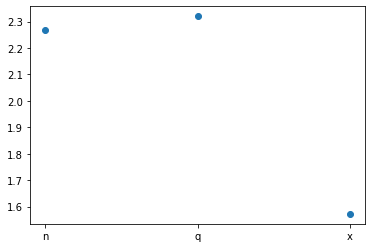

In [4]:
# investigate mean of damage grade depending on roof type 
plt.scatter(df['roof_type'].unique(),df.groupby(['roof_type']).mean()['damage_grade'])
plt.show()

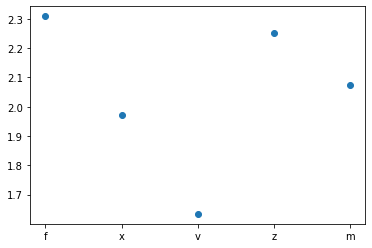

In [5]:
# investigate mean of damage grade depending on ground floor type 
plt.scatter(df['ground_floor_type'].unique(),df.groupby(['ground_floor_type']).mean()['damage_grade'])
plt.show()

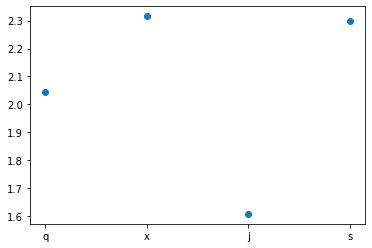

In [6]:
# investigate mean of damage grade depending on other floor type 
plt.scatter(df['other_floor_type'].unique(),df.groupby(['other_floor_type']).mean()['damage_grade'])
plt.show()

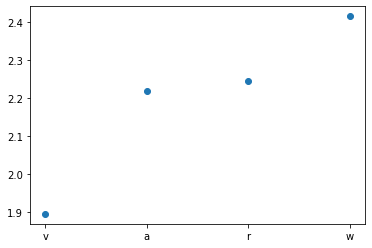

In [7]:
# investigate mean of damage grade depending on legal ownership status
plt.scatter(df['legal_ownership_status'].unique(),df.groupby(['legal_ownership_status']).mean()['damage_grade'])
plt.show()

# II. Preprocess dataset

In [8]:
# apply features function where encoding, scaling and adding means of categorical features from above happens
df=features(df)

In [9]:
display(df)

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade,mean_dmggeo_level_1_id,mean_dmggeo_level_2_id,mean_dmgfoundation_type,...,foundation_type_h,foundation_type_i,foundation_type_r,foundation_type_u,foundation_type_w,roof_type_n,roof_type_q,roof_type_x,ground_floor_type_f,ground_floor_type_m,ground_floor_type_v,ground_floor_type_x,ground_floor_type_z,other_floor_type_j,other_floor_type_q,other_floor_type_s,other_floor_type_x,position_j,position_o,position_s,position_t,plan_configuration_a,plan_configuration_c,plan_configuration_d,plan_configuration_f,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_a,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w
0,802906,6,487,12198,0.125,30,0.050505,0.100000,1,1,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,3.0,2.161724,2.740741,2.329573,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,28830,8,900,2812,0.125,10,0.070707,0.166667,0,1,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,2.0,2.485273,2.487437,2.329573,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,94947,21,363,8973,0.125,10,0.040404,0.100000,0,1,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,3.0,2.563369,2.518750,2.329573,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,590882,22,418,10694,0.125,10,0.050505,0.100000,0,1,0,0,0,0,1,1,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,2.0,2.000960,2.107317,2.329573,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,201944,11,131,1488,0.250,30,0.070707,0.233333,1,0,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,3.0,2.337713,2.348748,2.329573,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347464,310028,4,605,3623,0.250,70,0.191919,0.133333,0,1,0,0,0,0,1,0,0,0,0,0.111111,1,1,0,0,0,0,0,0,0,0,0,NaN,2.162136,2.122642,2.329573,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
347465,663567,10,1407,11907,0.250,25,0.050505,0.166667,1,1,1,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,NaN,2.341954,2.337176,2.329573,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
347466,1049160,22,1136,7712,0.000,50,0.020202,0.033333,0,1,0,0,0,0,1,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,NaN,2.000960,2.019704,2.329573,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0

## Investigate means of several numerical features

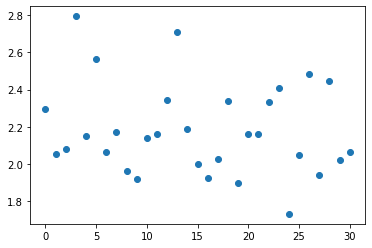

In [10]:
# investigate mean of damage grade depending on geo level 1 id
plt.scatter(df['geo_level_1_id'].unique(),df.groupby(['geo_level_1_id']).mean()['damage_grade'])
plt.show()

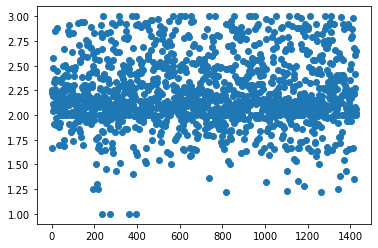

In [11]:
# investigate mean of damage grade depending on geo level 2 id
plt.scatter(df['geo_level_2_id'].unique(),df.groupby(['geo_level_2_id']).mean()['damage_grade'])
plt.show()

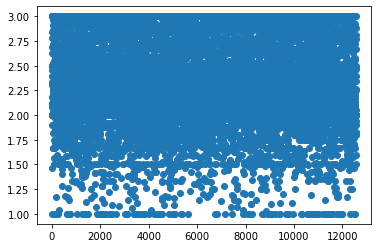

In [12]:
# investigate mean of damage grade depending on geo level 3 id
plt.scatter(df['geo_level_3_id'].unique(),df.groupby(['geo_level_3_id']).mean()['damage_grade'])
plt.show()

# III. Feature Selection and Rebalancing

## Investigate Correlations 

C:\Users\Kim\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """


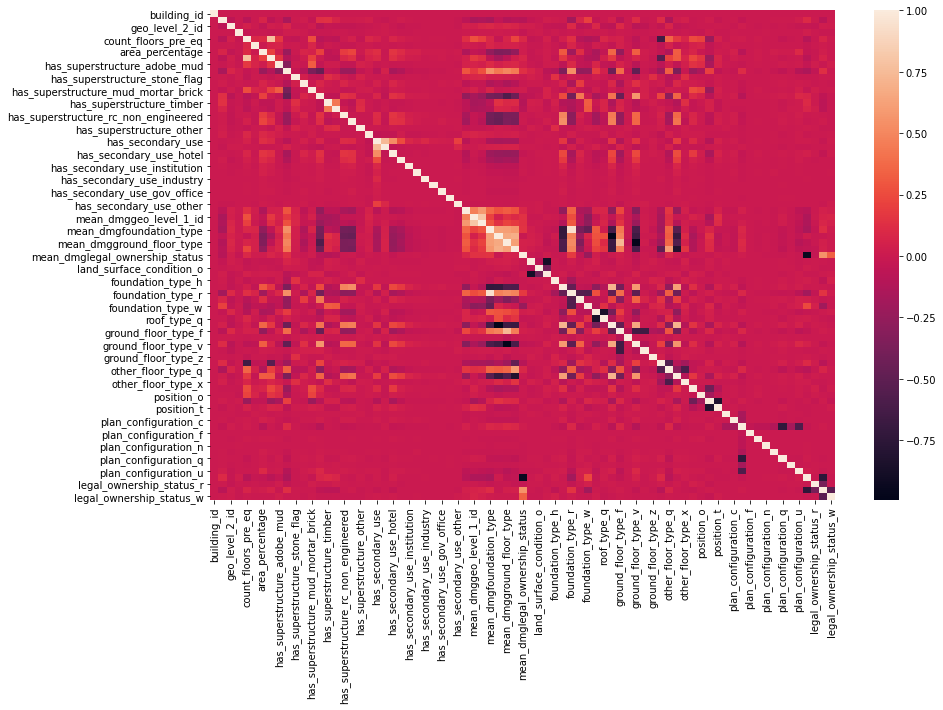

In [13]:
# investigate correlation heatmap
corrMatrix=df.corr()
f=plt.figure(figsize=(14,9))
sns.heatmap(corrMatrix, annot=False)
f.show()

In [14]:
# print all correlated features and drop them from the dataset
correlated_features = set()
correlation_matrix = df.corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            print(f"The following features are correlated: {correlation_matrix.columns[i]} and {correlation_matrix.columns[j]}. Correlation = {round(abs(correlation_matrix.iloc[i, j]),2)}")
            colname = correlation_matrix.columns[j] # changed from i to j here for dropping
            correlated_features.add(colname)

print(f"Drop the following features: {correlated_features}")
df=df.drop(columns=correlated_features)

The following features are correlated: mean_dmggeo_level_2_id and mean_dmggeo_level_1_id. Correlation = 0.8
The following features are correlated: land_surface_condition_t and land_surface_condition_n. Correlation = 0.88
The following features are correlated: foundation_type_r and mean_dmgfoundation_type. Correlation = 0.94
The following features are correlated: roof_type_q and roof_type_n. Correlation = 0.85
The following features are correlated: roof_type_x and mean_dmgroof_type. Correlation = 0.99
The following features are correlated: ground_floor_type_v and mean_dmgground_floor_type. Correlation = 0.99
The following features are correlated: other_floor_type_s and mean_dmgother_floor_type. Correlation = 0.82
The following features are correlated: position_t and position_s. Correlation = 0.83
The following features are correlated: legal_ownership_status_a and mean_dmglegal_ownership_status. Correlation = 0.95
Drop the following features: {'mean_dmgother_floor_type', 'mean_dmggeo_lev

In [15]:
# drop features with low amount of entries --> hier: die Analyse verwenden!!!
drop_col = df.sum()[df.sum() < 100].index
drop_col
df=df.drop(columns=drop_col)

# IV. Split dataset back into train and test set


In [16]:
data_train, target_train, data_test = split_data(df)
data_train

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_other,mean_dmggeo_level_2_id,land_surface_condition_o,land_surface_condition_t,foundation_type_h,foundation_type_i,foundation_type_r,foundation_type_u,foundation_type_w,roof_type_q,roof_type_x,ground_floor_type_f,ground_floor_type_m,ground_floor_type_v,ground_floor_type_x,ground_floor_type_z,other_floor_type_j,other_floor_type_q,other_floor_type_s,other_floor_type_x,position_j,position_o,position_t,plan_configuration_a,plan_configuration_c,plan_configuration_d,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_a,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,0.125,30,0.050505,0.100000,1,1,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,2.740741,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
28830,8,900,2812,0.125,10,0.070707,0.166667,0,1,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,2.487437,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
94947,21,363,8973,0.125,10,0.040404,0.100000,0,1,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,2.518750,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
590882,22,418,10694,0.125,10,0.050505,0.100000,0,1,0,0,0,0,1,1,0,0,0,0.111111,0,0,0,0,0,0,0,0,2.107317,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
201944,11,131,1488,0.250,30,0.070707,0.233333,1,0,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,2.348748,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688636,25,1335,1621,0.000,55,0.050505,0.033333,0,1,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,1.931034,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
669485,17,715,2060,0.125,0,0.050505,0.100000,0,1,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,2.931034,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
602512,17,51,8163,0.250,55,0.050505,0.166667,0,1,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,2.894895,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


# V. Model building - Baselines

## Train-Test-Split

In [17]:
# train-test split with stratify
data_train, data_test, target_train, target_test = train_test_split(data_train, target_train, test_size=0.2, random_state=42, stratify=target_train)

In [18]:
#scale geo_features for logistic regression and runtime --> auch das schon vorher machen??? --> geo_level speichern???
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id','age']
geo_level_data_train =  data_train.copy()[geo_features]
scaler = MinMaxScaler()
data_train[geo_features] = scaler.fit_transform(data_train[geo_features])
data_train

C:\Users\Kim\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\Kim\Anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_other,mean_dmggeo_level_2_id,land_surface_condition_o,land_surface_condition_t,foundation_type_h,foundation_type_i,foundation_type_r,foundation_type_u,foundation_type_w,roof_type_q,roof_type_x,ground_floor_type_f,ground_floor_type_m,ground_floor_type_v,ground_floor_type_x,ground_floor_type_z,other_floor_type_j,other_floor_type_q,other_floor_type_s,other_floor_type_x,position_j,position_o,position_t,plan_configuration_a,plan_configuration_c,plan_configuration_d,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_a,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
716310,0.700000,0.655221,0.474731,0.250,0.020101,0.050505,0.133333,0,1,0,0,0,0,1,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,2.356608,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
283080,0.100000,0.861247,0.087465,0.125,0.020101,0.050505,0.100000,1,1,0,0,0,0,1,1,0,0,0,0.111111,0,0,0,0,0,0,0,0,2.304688,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
690774,0.700000,0.854240,0.215281,0.250,0.045226,0.050505,0.100000,0,1,0,0,0,0,0,0,0,0,0,0.444444,0,0,0,0,0,0,0,0,2.351499,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
904803,0.666667,0.110722,0.195145,0.125,0.010050,0.060606,0.100000,0,0,0,0,0,0,1,1,0,0,0,0.111111,0,0,0,0,0,0,0,0,1.895238,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
991971,0.300000,0.469516,0.475686,0.125,0.000000,0.080808,0.133333,0,0,0,0,0,0,0,0,1,0,0,0.111111,0,0,0,0,0,0,0,0,2.123153,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
819626,0.266667,0.829713,0.066057,0.000,0.010050,0.050505,0.100000,0,1,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,2.665236,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
865223,0.133333,0.100911,0.457700,0.125,0.000000,0.070707,0.066667,0,1,0,0,0,0,1,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,2.294545,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
363536,0.900000,0.384022,0.089057,0.250,0.020101,0.181818,0.166667,1,0,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,2.511690,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [19]:
geo_level_data_train

,geo_level_1_id,geo_level_2_id,geo_level_3_id,age
building_id,,,,
716310,21,935,5965,20
283080,3,1229,1099,20
690774,21,1219,2705,45
904803,20,158,2452,10
991971,9,670,5977,0
...,...,...,...,...
819626,8,1184,830,10
865223,4,144,5751,0
363536,27,548,1119,20


## Rebalance Train Set

Text(0, 0.5, 'Frequency')

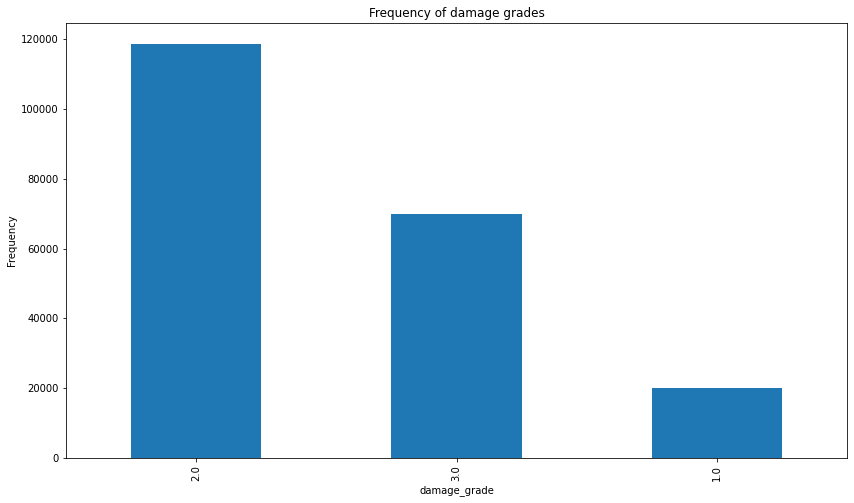

In [20]:
# investigate distribution of target variable
ax = target_train.value_counts().plot(kind='bar', figsize=(14,8), title="Frequency of damage grades")
ax.set_xlabel("damage_grade")
ax.set_ylabel("Frequency")

Text(0, 0.5, 'Frequency')

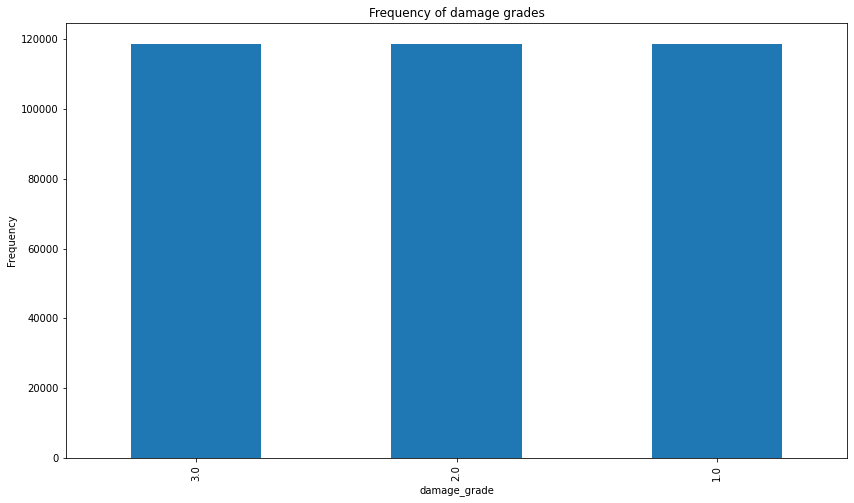

In [21]:
# choose to randomly oversample the train dataset as class 2 is highly over represented for our target variable damage grade
sampler = RandomOverSampler()
train_balanced_data, train_balanced_target = sampler.fit_resample(data_train, target_train)

ax = train_balanced_target.value_counts().plot(kind='bar', figsize=(14,8), title="Frequency of damage grades")
ax.set_xlabel("damage_grade")
ax.set_ylabel("Frequency")

In [22]:
train_balanced_data

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_other,mean_dmggeo_level_2_id,land_surface_condition_o,land_surface_condition_t,foundation_type_h,foundation_type_i,foundation_type_r,foundation_type_u,foundation_type_w,roof_type_q,roof_type_x,ground_floor_type_f,ground_floor_type_m,ground_floor_type_v,ground_floor_type_x,ground_floor_type_z,other_floor_type_j,other_floor_type_q,other_floor_type_s,other_floor_type_x,position_j,position_o,position_t,plan_configuration_a,plan_configuration_c,plan_configuration_d,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_a,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w
0,0.700000,0.655221,0.474731,0.250,0.020101,0.050505,0.133333,0,1,0,0,0,0,1,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,2.356608,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.100000,0.861247,0.087465,0.125,0.020101,0.050505,0.100000,1,1,0,0,0,0,1,1,0,0,0,0.111111,0,0,0,0,0,0,0,0,2.304688,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.700000,0.854240,0.215281,0.250,0.045226,0.050505,0.100000,0,1,0,0,0,0,0,0,0,0,0,0.444444,0,0,0,0,0,0,0,0,2.351499,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.666667,0.110722,0.195145,0.125,0.010050,0.060606,0.100000,0,0,0,0,0,0,1,1,0,0,0,0.111111,0,0,0,0,0,0,0,0,1.895238,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.300000,0.469516,0.475686,0.125,0.000000,0.080808,0.133333,0,0,0,0,0,0,0,0,1,0,0,0.111111,0,0,0,0,0,0,0,0,2.123153,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355816,0.700000,0.386125,0.874015,0.125,0.010050,0.070707,0.100000,0,1,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,2.426901,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
355817,0.233333,0.601962,0.417827,0.125,0.010050,0.040404,0.100000,0,1,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,2.409594,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
355818,0.566667,0.732306,0.048468,0.000,0.015075,0.050505,0.066667,0,1,0,0,0,0,1,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,2.804781,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
355819,0.266667,0.066573,0.528532,0.000,0.005025,0.040404,0.000000,0,1,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,2.823276,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


# Decision Tree

## ohne Rebalance

In [23]:
dt = DecisionTreeClassifier().fit(data_train,target_train)
prediction = dt.predict(data_test)
acc = accuracy_score(target_test,prediction) 
f1_mic= f1_score(target_test,prediction,average='micro') 
f1_mac= f1_score(target_test,prediction,average='macro') 
pr= precision_score(target_test,prediction,average='micro') 
re= recall_score(target_test,prediction,average='micro') 
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score micro on test set: {:.4f}".format(f1_mic))
print("The F1-Score macro on test set: {:.4f}".format(f1_mac))
print("The Precision-Score on test set: {:.4f}".format(pr))
print("The Recall-Score on test set: {:.4f}".format(re))
print('Confusion Matrix : \n' + str(confusion_matrix(target_test,prediction)))

The Accuracy on test set: 0.6585
The F1-Score micro on test set: 0.6585
The F1-Score macro on test set: 0.6107
The Precision-Score on test set: 0.6585
The Recall-Score on test set: 0.6585
Confusion Matrix : 
[[ 2608  2100   317]
 [ 2360 20898  6394]
 [  350  6277 10817]]


## mit Rebalance

In [24]:
dt = DecisionTreeClassifier().fit(train_balanced_data, train_balanced_target)
prediction = dt.predict(data_test)
acc = accuracy_score(target_test,prediction) 
f1_mic= f1_score(target_test,prediction,average='micro') 
f1_mac= f1_score(target_test,prediction,average='macro') 
pr= precision_score(target_test,prediction,average='micro') 
re= recall_score(target_test,prediction,average='micro') 
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score micro on test set: {:.4f}".format(f1_mic))
print("The F1-Score macro on test set: {:.4f}".format(f1_mac))
print("The Precision-Score on test set: {:.4f}".format(pr))
print("The Recall-Score on test set: {:.4f}".format(re))
print('Confusion Matrix : \n' + str(confusion_matrix(target_test,prediction)))

The Accuracy on test set: 0.6539
The F1-Score micro on test set: 0.6539
The F1-Score macro on test set: 0.6047
The Precision-Score on test set: 0.6539
The Recall-Score on test set: 0.6539
Confusion Matrix : 
[[ 2514  2214   297]
 [ 2311 20769  6572]
 [  319  6325 10800]]


# Logistic Regression

## ohne Rebalance

In [25]:
lr = LogisticRegression(max_iter=10000).fit(data_train, target_train)
prediction = lr.predict(data_test)
acc = accuracy_score(target_test,prediction) 
f1_mic= f1_score(target_test,prediction,average='micro') 
f1_mac= f1_score(target_test,prediction,average='macro') 
pr= precision_score(target_test,prediction,average='micro') 
re= recall_score(target_test,prediction,average='micro') 
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score micro on test set: {:.4f}".format(f1_mic))
print("The F1-Score macro on test set: {:.4f}".format(f1_mac))
print("The Precision-Score on test set: {:.4f}".format(pr))
print("The Recall-Score on test set: {:.4f}".format(re))
print('Confusion Matrix : \n' + str(confusion_matrix(target_test,prediction)))

The Accuracy on test set: 0.6723
The F1-Score micro on test set: 0.6723
The F1-Score macro on test set: 0.5840
The Precision-Score on test set: 0.6723
The Recall-Score on test set: 0.6723
Confusion Matrix : 
[[ 1675  3273    77]
 [ 1063 24558  4031]
 [   58  8580  8806]]


## mit Rebalance

In [26]:
lr = LogisticRegression(max_iter=10000).fit(train_balanced_data, train_balanced_target)
prediction = lr.predict(data_test)
acc = accuracy_score(target_test,prediction) 
f1_mic= f1_score(target_test,prediction,average='micro') 
f1_mac= f1_score(target_test,prediction,average='macro') 
pr= precision_score(target_test,prediction,average='micro') 
re= recall_score(target_test,prediction,average='micro') 
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score micro on test set: {:.4f}".format(f1_mic))
print("The F1-Score macro on test set: {:.4f}".format(f1_mac))
print("The Precision-Score on test set: {:.4f}".format(pr))
print("The Recall-Score on test set: {:.4f}".format(re))

The Accuracy on test set: 0.6037
The F1-Score micro on test set: 0.6037
The F1-Score macro on test set: 0.5788
The Precision-Score on test set: 0.6037
The Recall-Score on test set: 0.6037


## Grid Search

In [ ]:
# grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
# logreg_cv=GridSearchCV(lr,grid,cv=10)
# logreg_cv.fit(data_train, target_train)
# prediction = logreg_cv.predict(data_test)

# print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)

# # New Model Evaluation metrics 
# acc = accuracy_score(target_test,prediction) 
# f1_mic= f1_score(target_test,prediction,average='micro') 
# f1_mac= f1_score(target_test,prediction,average='macro') 
# pr= precision_score(target_test,prediction,average='micro') 
# re= recall_score(target_test,prediction,average='micro') 
# print("The Accuracy on test set: {:.4f}".format(acc))
# print("The F1-Score micro on test set: {:.4f}".format(f1_mic))
# print("The F1-Score macro on test set: {:.4f}".format(f1_mac))
# print("The Precision-Score on test set: {:.4f}".format(pr))
# print("The Recall-Score on test set: {:.4f}".format(re))

# #Logistic Regression (Grid Search) Confusion matrix
# confusion_matrix(target_train,prediction)

Rebalance nötig?

# SVM

### ohne Rebalance

In [ ]:
# sv = SVC(C=1, kernel ='rbf',decision_function_shape='ovo').fit(data_train, target_train)
# prediction = sv.predict(data_test)
# acc = accuracy_score(target_test,prediction) 
# f1_mic= f1_score(target_test,prediction,average='micro') 
# f1_mac= f1_score(target_test,prediction,average='macro') 
# pr= precision_score(target_test,prediction,average='micro') 
# re= recall_score(target_test,prediction,average='micro') 
# print("The Accuracy on test set: {:.4f}".format(acc))
# print("The F1-Score micro on test set: {:.4f}".format(f1_mic))
# print("The F1-Score macro on test set: {:.4f}".format(f1_mac))
# print("The Precision-Score on test set: {:.4f}".format(pr))
# print("The Recall-Score on test set: {:.4f}".format(re))
# print('Confusion Matrix : \n' + str(confusion_matrix(target_test,prediction)))

## mit Relabance

In [ ]:
# sv = SVC(C=1, kernel ='rbf',decision_function_shape='ovo').fit(train_balanced_data, train_balanced_target)
# prediction = sv.predict(data_test)
# acc = accuracy_score(target_test,prediction) 
# f1_mic= f1_score(target_test,prediction,average='micro') 
# f1_mac= f1_score(target_test,prediction,average='macro') 
# pr= precision_score(target_test,prediction,average='micro') 
# re= recall_score(target_test,prediction,average='micro') 
# print("The Accuracy on test set: {:.4f}".format(acc))
# print("The F1-Score micro on test set: {:.4f}".format(f1_mic))
# print("The F1-Score macro on test set: {:.4f}".format(f1_mac))
# print("The Precision-Score on test set: {:.4f}".format(pr))
# print("The Recall-Score on test set: {:.4f}".format(re))
# print('Confusion Matrix : \n' + str(confusion_matrix(target_test,prediction)))

# KNN

In [ ]:
knn = KNeighborsClassifier().fit(data_train,target_train)
prediction = knn.predict(data_test)
acc = accuracy_score(target_test,prediction) 
f1_mic= f1_score(target_test,prediction,average='micro') 
f1_mac= f1_score(target_test,prediction,average='macro') 
pr= precision_score(target_test,prediction,average='micro') 
re= recall_score(target_test,prediction,average='micro') 
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score micro on test set: {:.4f}".format(f1_mic))
print("The F1-Score macro on test set: {:.4f}".format(f1_mac))
print("The Precision-Score on test set: {:.4f}".format(pr))
print("The Recall-Score on test set: {:.4f}".format(re))
print('Confusion Matrix : \n' + str(confusion_matrix(target_test,prediction)))

In [ ]:
knn = KNeighborsClassifier().fit(train_balanced_data, train_balanced_target)
prediction = knn.predict(data_test)
acc = accuracy_score(target_test,prediction) 
f1_mic= f1_score(target_test,prediction,average='micro') 
f1_mac= f1_score(target_test,prediction,average='macro') 
pr= precision_score(target_test,prediction,average='micro') 
re= recall_score(target_test,prediction,average='micro') 
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score micro on test set: {:.4f}".format(f1_mic))
print("The F1-Score macro on test set: {:.4f}".format(f1_mac))
print("The Precision-Score on test set: {:.4f}".format(pr))
print("The Recall-Score on test set: {:.4f}".format(re))
print('Confusion Matrix : \n' + str(confusion_matrix(target_test,prediction)))

# MISSING: Baseline Model XGBoost

## --> Result: Performance is better without balancing! We will continue without it

# VI. Feature Engineering: Generate new Features

In [46]:
# Wieso hier neu laden? Vorher wurde doch schon was damit gemacht!? Würde dann verloren gehen
# 
#train_values = pd.read_csv('../data/external/train_values.csv', index_col='building_id')
#train_target = pd.read_csv('../data/external/train_labels.csv', index_col='building_id')
#test_values = pd.read_csv('../data/external/test_values.csv', index_col='building_id')

#df=merge_data(train_values, train_target, test_values)
#df=df.reset_index()
#df=features(df)
#pd.set_option('display.max_columns', None)

#display(df)

#df = feature_engineering_geo_3(df)
#df

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade,mean_dmggeo_level_1_id,mean_dmggeo_level_2_id,mean_dmgfoundation_type,mean_dmgroof_type,mean_dmgground_floor_type,mean_dmgother_floor_type,mean_dmglegal_ownership_status,land_surface_condition_n,land_surface_condition_o,land_surface_condition_t,foundation_type_h,foundation_type_i,foundation_type_r,foundation_type_u,foundation_type_w,roof_type_n,roof_type_q,roof_type_x,ground_floor_type_f,ground_floor_type_m,ground_floor_type_v,ground_floor_type_x,ground_floor_type_z,other_floor_type_j,other_floor_type_q,other_floor_type_s,other_floor_type_x,position_j,position_o,position_s,position_t,plan_configuration_a,plan_configuration_c,plan_configuration_d,plan_configuration_f,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_a,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w
0,802906,6,487,12198,0.125,30,0.050505,0.100000,1,1,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,3.0,2.161724,2.740741,2.329573,2.269637,2.309104,2.315751,2.244063,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,28830,8,900,2812,0.125,10,0.070707,0.166667,0,1,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,2.0,2.485273,2.487437,2.329573,2.269637,2.250714,2.315751,2.244063,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,94947,21,363,8973,0.125,10,0.040404,0.100000,0,1,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,3.0,2.563369,2.518750,2.329573,2.269637,2.309104,2.297344,2.244063,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,590882,22,418,10694,0.125,10,0.050505,0.100000,0,1,0,0,0,0,1,1,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,2.0,2.000960,2.107317,2.329573,2.269637,2.309104,2.297344,2.244063,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,201944,11,131,1488,0.250,30,0.070707,0.233333,1,0,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,0,0,0,3.0,2.337713,2.348748,2.329573,2.269637,2.309104,2.297344,2.244063,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347464,310028,4,605,3623,0.250,70,0.191919,0.133333,0,1,0,0,0,0,1,0,0,0,0,0.111111,1,1,0,0,0,0,0,0,0,0,0,NaN,2.162136,2.122642,2.329573,2.320173,2.309104,2.315751,2.415764,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
347465,663567,10,1407,11907,0.250,25,0.050505,0.166667,1,1,1,0,0,0,0,0,0,0

In [25]:
data_train[geo_features] = geo_level_data_train # reset geo_levels -> have to change afterwards again!
df=merge_data(data_train, target_train, data_test)
df=df.reset_index()
pd.set_option('display.max_columns', None)

display(df)
df = feature_engineering(df,3) # second parameter indicates whether to use 3 or 4 geo_level_1 districts
display(df)

C:\Users\Kim\Anaconda3\lib\site-packages\pandas\core\frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_other,mean_dmggeo_level_2_id,land_surface_condition_o,land_surface_condition_t,foundation_type_h,foundation_type_i,foundation_type_r,foundation_type_u,foundation_type_w,roof_type_q,roof_type_x,ground_floor_type_f,ground_floor_type_m,ground_floor_type_v,ground_floor_type_x,ground_floor_type_z,other_floor_type_j,other_floor_type_q,other_floor_type_s,other_floor_type_x,position_j,position_o,position_t,plan_configuration_a,plan_configuration_c,plan_configuration_d,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_a,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w,damage_grade
0,716310,21,935,5965,0.250,20,0.050505,0.133333,0,1,0,0,0,0,1,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,2.356608,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0
1,283080,3,1229,1099,0.125,20,0.050505,0.100000,1,1,0,0,0,0,1,1,0,0,0,0.111111,0,0,0,0,0,0,0,0,2.304688,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0
2,690774,21,1219,2705,0.250,45,0.050505,0.100000,0,1,0,0,0,0,0,0,0,0,0,0.444444,0,0,0,0,0,0,0,0,2.351499,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
3,904803,20,158,2452,0.125,10,0.060606,0.100000,0,0,0,0,0,0,1,1,0,0,0,0.111111,0,0,0,0,0,0,0,0,1.895238,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0
4,991971,9,670,5977,0.125,0,0.080808,0.133333,0,0,0,0,0,0,0,0,1,0,0,0.111111,0,0,0,0,0,0,0,0,2.123153,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260596,689970,4,334,9226,0.250,10,0.050505,0.166667,0,1,0,0,0,0,0,0,0,0,0,0.000000,0,0,0,0,0,0,0,0,2.150289,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN
260597,1035221,8,145,9862,0.125,0,0.090909,0.100000,0,1,0,0,0,0,0,0,0,0,0,0.111111,1,0,1,0,0,0,0,0,2.686131,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN
260598,1049706,25,725,5436,0.125,20,0.070707,0.100000,1,1,0,0,1,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,2.025641,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN
260599,23598,5,601,3024,0.125,35,0.050505,0.066667,0,1,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,1.972222,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN


,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_other,mean_dmggeo_level_2_id,land_surface_condition_o,land_surface_condition_t,foundation_type_h,foundation_type_i,foundation_type_r,foundation_type_u,foundation_type_w,roof_type_q,roof_type_x,ground_floor_type_f,ground_floor_type_m,ground_floor_type_v,ground_floor_type_x,ground_floor_type_z,other_floor_type_j,other_floor_type_q,other_floor_type_s,other_floor_type_x,position_j,position_o,position_t,plan_configuration_a,plan_configuration_c,plan_configuration_d,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_a,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w,damage_grade,district_class_2,district_class_1,district_class_3,age_u_40,age_40_100,age_ue_100,low_mortar_percentage,high_mortar_percentage,low_percentage_r,high_percentage_r,fragile,stable,ft_imp_1_pos,ft_high_imp_1_pos
0,716310,0.700000,0.655221,0.474656,0.250,0.020101,0.050505,0.133333,0,1,0,0,0,0,1,0,0,0,0,0.111111,0,0,0,0,0,0,0,0,2.356608,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,1.0,0.0,0.0,1.0,0.0,0.0,0,1,0,1,1.0,0.0,0.0,0.0
1,283080,0.100000,0.861247,0.087451,0.125,0.020101,0.050505,0.100000,1,1,0,0,0,0,1,1,0,0,0,0.111111,0,0,0,0,0,0,0,0,2.304688,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,1.0,0.0,0.0,1.0,0.0,0.0,1,0,0,1,1.0,0.0,0.0,0.0
2,690774,0.700000,0.854240,0.215246,0.250,0.045226,0.050505,0.100000,0,1,0,0,0,0,0,0,0,0,0,0.444444,0,0,0,0,0,0,0,0,2.351499,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0,1,0,1,1.0,0.0,0.0,0.0
3,904803,0.666667,0.110722,0.195114,0.125,0.010050,0.060606,0.100000,0,0,0,0,0,0,1,1,0,0,0,0.111111,0,0,0,0,0,0,0,0,1.895238,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,1,0,1,0,1.0,0.0,1.0,0.0
4,991971,0.300000,0.469516,0.475611,0.125,0.000000,0.080808,0.133333,0,0,0,0,0,0,0,0,1,0,0,0.111111,0,0,0,0,0,0,0,0,2.123153,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0,1,0,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260596,689970,0.133333,0.234057,0.734145,0.250,0.010050,0.050505,0.166667,0,1,0,0,0,0,0,0,0,0,0,0.000000,0,0,0,0,0,0,0,0,2.150289,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN,1.0,0.0,0.0,1.0,0.0,0.0,0,1,0,1,1.0,0.0,0.0,0.0
260597,1035221,0.266667,0.101612,0.784754,0.125,0.000000,0.090909,0.100000,0,1,0,0,0,0,0,0,0,0,0,0.111111,1,0,1,0,0,0,0,0,2.686131,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN,1.0,0.0,0.0,1.0,0.0,0.0,0,1,0,1,1.0,0.0,

In [26]:
df.describe()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_other,mean_dmggeo_level_2_id,land_surface_condition_o,land_surface_condition_t,foundation_type_h,foundation_type_i,foundation_type_r,foundation_type_u,foundation_type_w,roof_type_q,roof_type_x,ground_floor_type_f,ground_floor_type_m,ground_floor_type_v,ground_floor_type_x,ground_floor_type_z,other_floor_type_j,other_floor_type_q,other_floor_type_s,other_floor_type_x,position_j,position_o,position_t,plan_configuration_a,plan_configuration_c,plan_configuration_d,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_a,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w,damage_grade,district_class_2,district_class_1,district_class_3,age_u_40,age_40_100,age_ue_100,low_mortar_percentage,high_mortar_percentage,low_percentage_r,high_percentage_r,fragile,stable,ft_imp_1_pos,ft_high_imp_1_pos
count,2.606010e+05,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.00000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,208480.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000
mean,5.256755e+05,0.463345,0.491293,0.497961,0.141215,0.026668,0.070889,0.114479,0.088645,0.761935,0.034332,0.018235,0.068154,0.075268,0.254988,0.085011,0.042590,0.015859,0.014985,0.109328,0.111880,0.064378,0.033626,0.008101,0.000940,0.000361,0.001071,0.005119,2.238272,0.031911,0.831758,0.005556,0.040595,0.841117,0.054720,0.058012,0.236285,0.062099,0.804368,0.001949,0.094370,0.09546,0.003853,0.152889,0.634234,0.046155,0.166722,0.050967,0.008952,0.164604,0.000967,0.001247,0.959597,0.000610,0.021842,0.001328,0.014002,0.021151,0.005652,0.962924,0.010272,2.238272,0.413272,0.367992,0.083703,0.884452,0.107398,0.013384,0.276595,0.723405,0.168031,0.831969,0.831002,0.057559,0.257340,0.226860
std,3.045450e+05,0.267787,0.289216,0.290154,0.090958,0.073936,0.044366,0.063947,0.284231,0.425900,0.182081,0.133800,0.252010,0.263824,0.435855,0.278899,0.201931,0.124932,0.121491,0.046488,0.315219,0.245426,0.180265,0.089638,0.030647,0.018989,0.032703,0.071364,0.357779,0.175763,0.374082,0.074334,0.197350,0.365567,0.227433,0.233767,0.424800,0.241335,0.396687,0.044108,0.292344,0.29385,0.061950,0.359881,0.481645,0.209821,0.372728,0.219930,0.094193,0.370824,0.031082,0.035293,0.196902,0.024693,0.146167,0.036413,0.117500,0.143888,0.074969,0.188948,0.100831,0.611813,0.492422,0.482260,0.276942,0.319683,0.309619,0.114915,0.447315,0.447315,0.373894,0.373894,0.374751,0.232909,0.437169,0.41

In [24]:
display(get_unnecessary_ft(df))
df = drop_unnecessary_ft(df)

['has_secondary_use_institution',
 'has_secondary_use_school',
 'has_secondary_use_industry',
 'has_secondary_use_other',
 'ground_floor_type_m',
 'ground_floor_type_z',
 'plan_configuration_a',
 'plan_configuration_c',
 'plan_configuration_o',
 'plan_configuration_s',
 'legal_ownership_status_r']

## State of the art -Modell

In [5]:
train_data, train_target, test_data = split_data(df)
train_data

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,mean_dmggeo_level_1_id,mean_dmggeo_level_2_id,mean_dmgfoundation_type,mean_dmgroof_type,mean_dmgground_floor_type,mean_dmgother_floor_type,mean_dmglegal_ownership_status,land_surface_condition_n,land_surface_condition_o,land_surface_condition_t,foundation_type_h,foundation_type_i,foundation_type_r,foundation_type_u,foundation_type_w,roof_type_n,roof_type_q,roof_type_x,ground_floor_type_f,ground_floor_type_v,ground_floor_type_x,other_floor_type_j,other_floor_type_q,other_floor_type_s,other_floor_type_x,position_j,position_o,position_s,position_t,plan_configuration_d,plan_configuration_q,plan_configuration_u,legal_ownership_status_a,legal_ownership_status_v,legal_ownership_status_w,district_class_1,district_class_2,district_class_3,age_u_40,age_40_100,age_ue_100,low_mortar_percentage,high_mortar_percentage,low_percentage_r,high_percentage_r,fragile,stable
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
802906,0.200000,0.341275,0.970637,0.125,0.030151,0.050505,0.100000,1,1,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,2.161724,2.740741,2.329573,2.269637,2.309104,2.315751,2.244063,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0,1,0,1,1.0,0.0
28830,0.266667,0.630694,0.223761,0.125,0.010050,0.070707,0.166667,0,1,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,2.485273,2.487437,2.329573,2.269637,2.250714,2.315751,2.244063,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0,1,0,1,1.0,0.0
94947,0.700000,0.254380,0.714013,0.125,0.010050,0.040404,0.100000,0,1,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,2.563369,2.518750,2.329573,2.269637,2.309104,2.297344,2.244063,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0,1,0,1,1.0,0.0
590882,0.733333,0.292922,0.850959,0.125,0.010050,0.050505,0.100000,0,1,0,0,0,0,1,1,0,0,0,0.111111,0,0,0,0,2.000960,2.107317,2.329573,2.269637,2.309104,2.297344,2.244063,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0,1,0,1,1.0,0.0
201944,0.366667,0.091801,0.118405,0.250,0.030151,0.070707,0.233333,1,0,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,2.337713,2.348748,2.329573,2.269637,2.309104,2.297344,2.244063,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1,0,0,1,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688636,0.833333,0.935529,0.128989,0.000,0.055276,0.050505,0.033333,0,1,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,2.054054,1.931034,2.329573,2.269637,2.309104,2.042893,2.244063,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,1,0,1,1.0,0.0
669485,0.566667,0.501051,0.163921,0.125,0.000000,0.050505,0.100000,0,1,0,0,0,0,0,0,0,0,0,0.111111,0,0,0,0,2.794480,2.931034,2.329573,2.269637,2.309104,2.315751,2.244063,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0

In [9]:
train_data[(train_data['foundation_type_i'] == 1) & (train_data['ground_floor_type_v'] == 1) & (train_data['roof_type_x'] == 1)]

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,mean_dmggeo_level_1_id,mean_dmggeo_level_2_id,mean_dmgfoundation_type,mean_dmgroof_type,mean_dmgground_floor_type,mean_dmgother_floor_type,mean_dmglegal_ownership_status,land_surface_condition_n,land_surface_condition_o,land_surface_condition_t,foundation_type_h,foundation_type_i,foundation_type_r,foundation_type_u,foundation_type_w,roof_type_n,roof_type_q,roof_type_x,ground_floor_type_f,ground_floor_type_v,ground_floor_type_x,other_floor_type_j,other_floor_type_q,other_floor_type_s,other_floor_type_x,position_j,position_o,position_s,position_t,plan_configuration_d,plan_configuration_q,plan_configuration_u,legal_ownership_status_a,legal_ownership_status_v,legal_ownership_status_w,district_class_1,district_class_2,district_class_3,age_u_40,age_40_100,age_ue_100,low_mortar_percentage,high_mortar_percentage,low_percentage_r,high_percentage_r,fragile,stable
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
440102,0.233333,0.110021,0.418954,0.000,0.005025,0.101010,0.033333,0,0,0,0,0,0,0,0,1,0,0,0.222222,1,0,0,1,2.297726,1.939378,1.453351,1.572267,1.634205,2.042893,2.244063,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0,1,0,1,0.0,1.0
288541,0.333333,0.463210,0.674942,0.000,0.000000,0.111111,0.033333,0,0,0,0,0,1,0,0,0,1,0,0.000000,0,0,0,0,2.341954,2.305057,1.453351,1.572267,1.634205,2.042893,2.244063,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0,1,0,1,0.0,1.0
708530,0.866667,0.027330,0.858996,0.000,0.000000,0.161616,0.033333,0,0,0,0,0,0,0,0,0,1,0,0.111111,0,0,0,0,1.730887,1.532194,1.453351,1.572267,1.634205,2.042893,2.244063,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1,0,1,0,0.0,1.0
533100,0.900000,0.295725,0.755709,0.125,0.000000,0.131313,0.166667,0,0,0,0,0,0,0,0,1,0,0,0.000000,0,0,0,0,2.446457,2.581429,1.453351,1.572267,1.634205,1.607416,2.244063,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1,0,0,1,0.0,1.0
122112,0.366667,0.595655,0.373041,0.250,0.015075,0.070707,0.166667,0,0,0,1,0,0,0,0,1,0,0,0.111111,0,0,0,0,2.337713,2.354286,1.453351,1.572267,1.634205,1.607416,2.244063,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1,0,0,1,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
543155,0.566667,0.613875,0.964351,0.000,0.005025,0.181818,0.033333,0,0,0,0,0,0,0,0,1,0,0,0.111111,0,0,0,0,2.794480,2.897338,1.453351,1.572267,1.634205,2.042893,2.217244,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0,1,0,1,0.0,1.0
353176,0.866667,0.027330,0.726745,0.000,0.010050,0.161616,0.033333,0,0,0,0,0,0,0,0,1,0,0,0.111111,0,0,0,0,1.730887,1.532194,1.453351,1.572267,1.634205,2.042893,2.244063,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0

In [6]:
data_train, data_test, target_train, target_test = train_test_split(train_data, train_target, test_size=0.2, random_state=42, stratify=train_target)

In [7]:
model = XGBClassifier(use_label_encoder = True, max_depth=10,verbosity=2)
model.fit(data_train, target_train)
pred = model.predict(data_test)

acc = accuracy_score(target_test, pred)
f1_mic = f1_score(target_test, pred, average='micro')
f1_mac = f1_score(target_test, pred, average='macro')
print('The Accuracy is:{:,.4f}'.format(acc))
print('The f1_mic is:{:,.4f}'.format(f1_mic))
print('The f1_mac is:{:,.4f}'.format(f1_mac))

c:\users\luisa\projekte\dataminingi\quake\venv\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:47:58] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 1402 extra nodes, 0 pruned nodes, max_depth=10
[17:47:59] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 1472 extra nodes, 0 pruned nodes, max_depth=10
[17:47:59] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 1294 extra nodes, 0 pruned nodes, max_depth=10
[17:47:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:48:00] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 1436 extra nodes, 0 pruned nodes, max_de

[17:48:24] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 774 extra nodes, 0 pruned nodes, max_depth=10
[17:48:25] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 788 extra nodes, 0 pruned nodes, max_depth=10
[17:48:25] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 1086 extra nodes, 0 pruned nodes, max_depth=10
[17:48:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 990 extra nodes, 0 pruned nodes, max_depth=10
[17:48:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 882 extra nodes, 0 pruned nodes, max_depth=10
[17:48:27] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 1074 ex

[17:48:50] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 378 extra nodes, 0 pruned nodes, max_depth=10
[17:48:51] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 624 extra nodes, 0 pruned nodes, max_depth=10
[17:48:52] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 864 extra nodes, 0 pruned nodes, max_depth=10
[17:48:52] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 668 extra nodes, 0 pruned nodes, max_depth=10
[17:48:53] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 664 extra nodes, 0 pruned nodes, max_depth=10
[17:48:53] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 832 extr

[17:49:18] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 574 extra nodes, 0 pruned nodes, max_depth=10
[17:49:19] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 976 extra nodes, 0 pruned nodes, max_depth=10
[17:49:19] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 410 extra nodes, 0 pruned nodes, max_depth=10
[17:49:20] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 420 extra nodes, 0 pruned nodes, max_depth=10
[17:49:20] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 636 extra nodes, 0 pruned nodes, max_depth=10
[17:49:21] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 582 extr

[17:49:46] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 598 extra nodes, 0 pruned nodes, max_depth=10
[17:49:47] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 572 extra nodes, 0 pruned nodes, max_depth=10
[17:49:48] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 396 extra nodes, 0 pruned nodes, max_depth=10
[17:49:48] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 496 extra nodes, 0 pruned nodes, max_depth=10
[17:49:49] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 666 extra nodes, 0 pruned nodes, max_depth=10
[17:49:49] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 142 extr

[17:50:14] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 910 extra nodes, 0 pruned nodes, max_depth=10
[17:50:15] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 640 extra nodes, 0 pruned nodes, max_depth=10
[17:50:15] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 388 extra nodes, 0 pruned nodes, max_depth=10
[17:50:16] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 512 extra nodes, 0 pruned nodes, max_depth=10
[17:50:16] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 338 extra nodes, 0 pruned nodes, max_depth=10
[17:50:17] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 616 extr

[17:50:38] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 636 extra nodes, 0 pruned nodes, max_depth=10
[17:50:38] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 276 extra nodes, 0 pruned nodes, max_depth=10
[17:50:39] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 516 extra nodes, 0 pruned nodes, max_depth=10
[17:50:39] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 444 extra nodes, 0 pruned nodes, max_depth=10
[17:50:40] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 586 extra nodes, 0 pruned nodes, max_depth=10
[17:50:40] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/tree/updater_prune.cc:101: tree pruning end, 480 extr

In [ ]:
#Korrelation
correlated_features = set()
correlation_matrix = df.corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            print(f"The following features are correlated: {correlation_matrix.columns[i]} and {correlation_matrix.columns[j]}. Correlation = {round(abs(correlation_matrix.iloc[i, j]),2)}")
            colname = correlation_matrix.columns[j]
            correlated_features.add(colname)
print(f"Drop the following features: {correlated_features}")
#drop correlated features
df=df.drop(columns=correlated_features)

## Split data into train and final test again

In [ ]:
data_train, target_train, data_test = split_data(df)
data_train

## split data into train and validation set

In [ ]:
data_train, data_test, target_train, target_test = train_test_split(data_train, target_train, test_size=0.2, random_state=42, stratify=target_train)

## Rebalance dataset

In [ ]:
sampler = RandomOverSampler()
train_balanced_data, train_balanced_target = sampler.fit_resample(data_train, target_train)

ax = train_balanced_target.value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Frequency of damage grades")
ax.set_xlabel("damage_grade")
ax.set_ylabel("Frequency")

# VII. Engineered Models without Hyperparameter Tuning

## Decision Tree ohne Rebalance

In [ ]:
dt = DecisionTreeClassifier().fit(data_train,target_train)
prediction = dt.predict(data_test)
acc = accuracy_score(target_test,prediction) 
f1_mic= f1_score(target_test,prediction,average='micro') 
f1_mac= f1_score(target_test,prediction,average='macro') 
pr= precision_score(target_test,prediction,average='micro') 
re= recall_score(target_test,prediction,average='micro') 
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score micro on test set: {:.4f}".format(f1_mic))
print("The F1-Score macro on test set: {:.4f}".format(f1_mac))
print("The Precision-Score on test set: {:.4f}".format(pr))
print("The Recall-Score on test set: {:.4f}".format(re))
print('Confusion Matrix : \n' + str(confusion_matrix(target_test,prediction)))

## Decision Tree mit Rebalance

In [ ]:
dt = DecisionTreeClassifier().fit(train_balanced_data, train_balanced_target)
prediction = dt.predict(data_test)
acc = accuracy_score(target_test,prediction) 
f1_mic= f1_score(target_test,prediction,average='micro') 
f1_mac= f1_score(target_test,prediction,average='macro') 
pr= precision_score(target_test,prediction,average='micro') 
re= recall_score(target_test,prediction,average='micro') 
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score micro on test set: {:.4f}".format(f1_mic))
print("The F1-Score macro on test set: {:.4f}".format(f1_mac))
print("The Precision-Score on test set: {:.4f}".format(pr))
print("The Recall-Score on test set: {:.4f}".format(re))
print('Confusion Matrix : \n' + str(confusion_matrix(target_test,prediction)))

## Logistic Regressin ohne Rebalance

In [ ]:
lr = LogisticRegression(max_iter=10000).fit(data_train, target_train)
prediction = lr.predict(data_test)
acc = accuracy_score(target_test,prediction) 
f1_mic= f1_score(target_test,prediction,average='micro') 
f1_mac= f1_score(target_test,prediction,average='macro') 
pr= precision_score(target_test,prediction,average='micro') 
re= recall_score(target_test,prediction,average='micro') 
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score micro on test set: {:.4f}".format(f1_mic))
print("The F1-Score macro on test set: {:.4f}".format(f1_mac))
print("The Precision-Score on test set: {:.4f}".format(pr))
print("The Recall-Score on test set: {:.4f}".format(re))
print('Confusion Matrix : \n' + str(confusion_matrix(target_test,prediction)))

## Logistic Regressin mit Rebalance

In [ ]:
lr = LogisticRegression(max_iter=10000).fit(train_balanced_data, train_balanced_target)
prediction = lr.predict(data_test)
acc = accuracy_score(target_test,prediction) 
f1_mic= f1_score(target_test,prediction,average='micro') 
f1_mac= f1_score(target_test,prediction,average='macro') 
pr= precision_score(target_test,prediction,average='micro') 
re= recall_score(target_test,prediction,average='micro') 
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score micro on test set: {:.4f}".format(f1_mic))
print("The F1-Score macro on test set: {:.4f}".format(f1_mac))
print("The Precision-Score on test set: {:.4f}".format(pr))
print("The Recall-Score on test set: {:.4f}".format(re))

## xgboost ohne Rebalance

In [ ]:
xgb = XGBClassifier(use_label_encoder = True).fit(data_train, target_train)
prediction = xgb.predict(data_test)
acc = accuracy_score(target_test,prediction) 
f1_mic= f1_score(target_test,prediction,average='micro') 
f1_mac= f1_score(target_test,prediction,average='macro') 
pr= precision_score(target_test,prediction,average='micro') 
re= recall_score(target_test,prediction,average='micro') 
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score micro on test set: {:.4f}".format(f1_mic))
print("The F1-Score macro on test set: {:.4f}".format(f1_mac))
print("The Precision-Score on test set: {:.4f}".format(pr))
print("The Recall-Score on test set: {:.4f}".format(re))
#0,7397

In [ ]:
from sklearn.model_selection import cross_val_score, KFold
# cross-validation
xgbm = XGBClassifier()
kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(xgb, data_train, target_train, cv=kfold, scoring='f1_micro')
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

In [ ]:
# A parameter grid for XGBoost
random_grid = {
        'n_estimators': [50, 100, 150, 200]
        'min_child_weight': [4,5,6,7],
        'gamma': [i/10.0 for i in range(3)],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [i/10.0 for i in range(1, 3)],
        'max_depth': range(3, 10),
        'learning_rate': [0.01, 0.1, 0.2, 0.3]
        }

In [ ]:
# # Use the random grid to search for best hyperparameters
# # First create the base model to tune
# xgbm = XGBClassifier()
# # Random search of parameters, using 3 fold cross validation, search across 100 different combinations
# rf_random = GridSearchCV(xgbm, random_grid, n_jobs=5, 
#                    cv=5, 
#                    scoring='f1_micro',
#                    verbose=2, refit=True)
# # Fit the random search model
# rf_random.fit(data_train, target_train)

In [ ]:
# best_random = rf_random.best_estimator_
# best_random.fit(data_train, target_train)
# prediction = best_random.predict(data_test)
# acc = accuracy_score(target_test,prediction) 
# f1_mic= f1_score(target_test,prediction,average='micro') 
# f1_mac= f1_score(target_test,prediction,average='macro') 
# pr= precision_score(target_test,prediction,average='micro') 
# re= recall_score(target_test,prediction,average='micro') 
# print("The Accuracy on test set: {:.4f}".format(acc))
# print("The F1-Score micro on test set: {:.4f}".format(f1_mic))
# print("The F1-Score macro on test set: {:.4f}".format(f1_mac))
# print("The Precision-Score on test set: {:.4f}".format(pr))
# print("The Recall-Score on test set: {:.4f}".format(re))

# Featuretools-package

In [ ]:
import featuretools as ft

In [ ]:
df

In [ ]:
# create an entity set with only one entity
es=ft.EntitySet(id="earthquake_data")

In [ ]:
# add dataset as entity
es = es.entity_from_dataframe(entity_id="damage", dataframe=df, index="building_id",)

In [ ]:
# create normalized entities based on geo_level
es = es.normalize_entity(base_entity_id="damage", new_entity_id="geo_data", index="geo_level_1_id",
                         additional_variables=["geo_level_2_id", "geo_level_3_id"])

In [ ]:
es

In [ ]:
feature_matrix, feature_defs = ft.dfs(entityset=es,target_entity="damage")

In [ ]:
feature_matrix

In [ ]:
df_features=feature_matrix.copy()
scaler = MinMaxScaler()
df_features[df_features.columns] = scaler.fit_transform(df_features[df_features.columns])
df_features['damage_grade']=feature_matrix['damage_grade']

In [ ]:
df_features

In [ ]:
df_features['damage_grade']

In [ ]:
#Korrelation
correlated_features = set()
correlation_matrix = df_features.corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            print(f"The following features are correlated: {correlation_matrix.columns[i]} and {correlation_matrix.columns[j]}. Correlation = {round(abs(correlation_matrix.iloc[i, j]),2)}")
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
print(f"Drop the following features: {correlated_features}")
#drop correlated features
df_features=df_features.drop(columns=correlated_features)

In [ ]:
df_features=df_features.drop(columns=['geo_data.MEAN(damage.damage_grade)'])

In [ ]:
df_features=df_features.drop(columns=['geo_data.SKEW(damage.damage_grade)'])

In [ ]:
df_features=df_features.reset_index()

In [ ]:
data_train, target_train, data_test = split_data(df_features)
data_train

In [ ]:
data_train, data_test, target_train, target_test = train_test_split(data_train, target_train, test_size=0.2, random_state=42)

In [ ]:
xgb = XGBClassifier(use_label_encoder = True).fit(data_train, target_train)
prediction = xgb.predict(data_test)
acc = accuracy_score(target_test,prediction) 
f1_mic= f1_score(target_test,prediction,average='micro') 
f1_mac= f1_score(target_test,prediction,average='macro') 
pr= precision_score(target_test,prediction,average='micro') 
re= recall_score(target_test,prediction,average='micro') 
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score micro on test set: {:.4f}".format(f1_mic))
print("The F1-Score macro on test set: {:.4f}".format(f1_mac))
print("The Precision-Score on test set: {:.4f}".format(pr))
print("The Recall-Score on test set: {:.4f}".format(re))

In [ ]:
# xgboost for feature importance on a regression problem
# get importance
importance = xgb.feature_importances_
# summarize feature importance
for i, v in enumerate(importance):
    print(f'Feature: {i} {data_train.columns[i]}, Score: {v}')

# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()


## hyperparameter

In [ ]:
#grid for xgboost
# Create the random grid
random_grid= {'min_child_weight':[ 4,5,6,7 ], 
              'gamma':[i/10.0 for i in range(1,4)],  
              'subsample':[1],
              'colsample_bytree':[1],
              'max_depth': [8]}

In [ ]:
# Use the random grid to search for best hyperparameters
from sklearn.model_selection import RandomizedSearchCV
# First create the base model to tune
xgbm = XGBClassifier()
# Random search of parameters, using 3 fold cross validation, search across 100 different combinations
rf_random = RandomizedSearchCV(estimator=xgbm, param_distributions=random_grid, n_iter=30, cv=5, verbose=2, random_state=42,scoring='f1_micro')
# Fit the random search model
rf_random.fit(data_train, target_train)

In [ ]:
best_random = rf_random.best_estimator_
best_random.fit(data_train, target_train)
prediction = best_random.predict(data_test)
acc = accuracy_score(target_test,prediction) 
f1_mic= f1_score(target_test,prediction,average='micro') 
f1_mac= f1_score(target_test,prediction,average='macro') 
pr= precision_score(target_test,prediction,average='micro') 
re= recall_score(target_test,prediction,average='micro') 
print("The Accuracy on test set: {:.4f}".format(acc))
print("The F1-Score micro on test set: {:.4f}".format(f1_mic))
print("The F1-Score macro on test set: {:.4f}".format(f1_mac))
print("The Precision-Score on test set: {:.4f}".format(pr))
print("The Recall-Score on test set: {:.4f}".format(re))

In [ ]:
rf_random.best_estimator_